# Splitter tutorial

This notebook presents the possibilities of splitters. They will help to split the train and test data.
RePlay offers several classes:

* TimeSplitter
* RandomSplitter
* NewUsersSplitter
* ColdUserRandomSplitter
* TwoStageSplitter

Each of them provides its own capabilities for data split.

### Split data

To split the data, you must call the `.split()` method on the Splitter object

### Return

Splitters return `train` and `test` cached DataFrame to compute them once and re-use for models training, inference and metrics calculation.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from replay.preprocessing import LabelEncoder, LabelEncodingRule

sns.set_theme(style="whitegrid", palette="muted")

## Get started

Download the dataset **MovieLens** and preprocess it with `DataPreparator` and `Indexer`

In [2]:
ratings = pd.read_csv('./data/ml1m_ratings.dat',sep="\t",names=["user_id", "item_id", "rating", "timestamp"], engine='python')
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')

In [3]:
ratings.head(5)

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id"),
        LabelEncodingRule("item_id"),
    ]
)
ratings = encoder.fit_transform(ratings)

/root/work/replay_gitlab/RePlay/replay/preprocessing/label_encoder.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_df[self._target_col][unknown_mask] = -1


For examples, we will use the first 20 users

In [78]:
log_limit_20 = ratings.query("user_id < 20 and timestamp < '2001-01-02'")

Function for viewing `train`, `test` data

In [79]:
def show_train_test(train, test):
    plt.figure(figsize=(25,12))
    train_plt = train
    train_plt["split"] = 'train'
    test_plt = test
    test_plt["split"] = 'test'
    pd_for_print = pd.concat((train_plt, test_plt), axis=0)
    pd_for_print["user_id"] = pd_for_print["user_id"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_id", hue="split",s=8*8)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()

Function for printing stats of df

In [80]:
def get_df_info(df: pd.DataFrame):
    print(f"Total rows {len(df)}, unique users: {df.user_id.nunique()}, unique items: {df.item_id.nunique()}")

## General parameters of splitters

All splitters has the following common parameters:
* `drop_cold_users` flag to drop cold (not presented in train part) users from test

* `drop_cold_items` flag to drop cold (not presented in train part) users from test

* `date_column` timestamp column name

* `query_column` query id column name

* `item_column` item id column name

## class TimeSplitter()

Split into train and test by date.

#### Parameters other than gneral

* `test_start` string "yyyy-mm-dd" , int unix timestamp, datetime or a fraction for test size to determine the date automatically


In this example `test_start` parameter will take fraction for test size

In [81]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.05,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [82]:
train, test = date_splitter.split(log_limit_20)

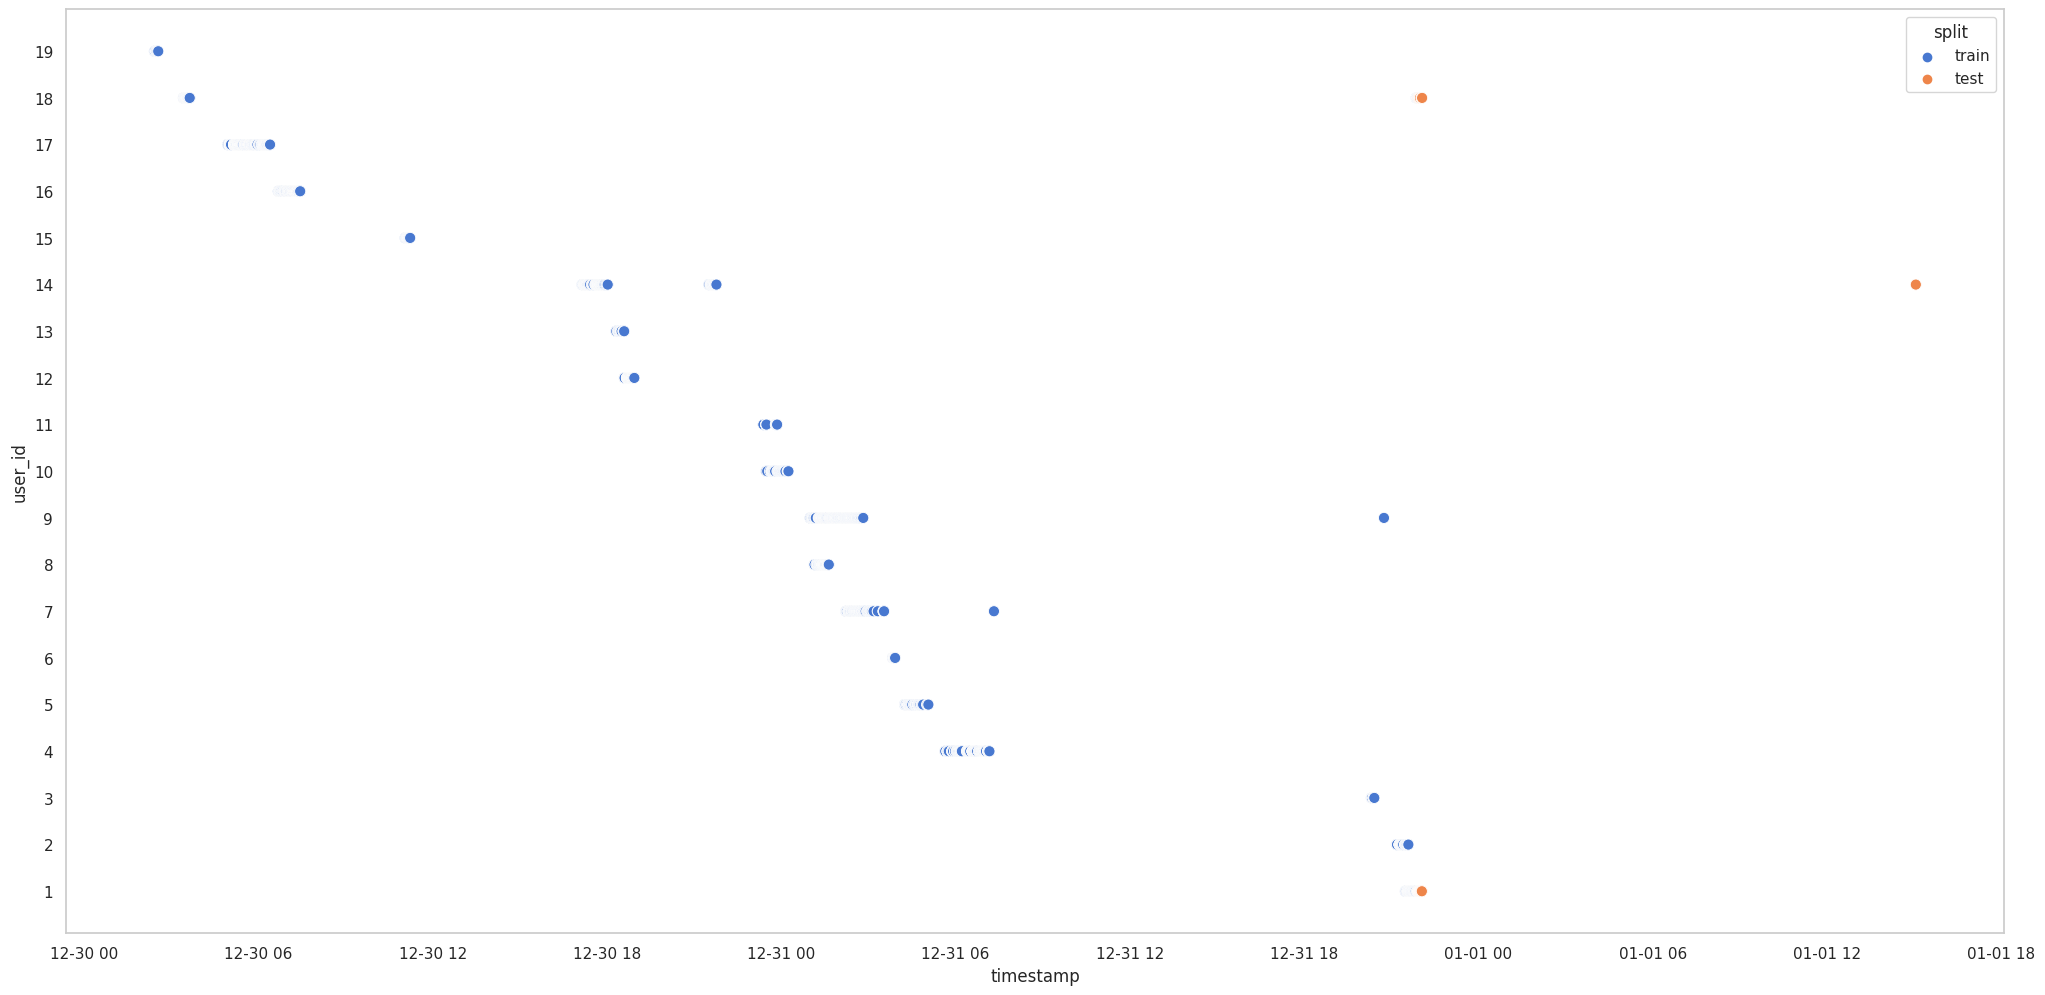

In [83]:
show_train_test(train, test)

In [84]:
get_df_info(train)

Total rows 2050, unique users: 19, unique items: 1054


In [85]:
get_df_info(test)

Total rows 58, unique users: 3, unique items: 58


In this example `test_start` parameter will take string "yyyy-mm-dd"

In [92]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold="2000-12-31",
    drop_cold_users=True,
    drop_cold_items=True,
    time_column_format="%Y-%m-%d",
    query_column="user_id",
)

In [93]:
train, test = date_splitter.split(log_limit_20)

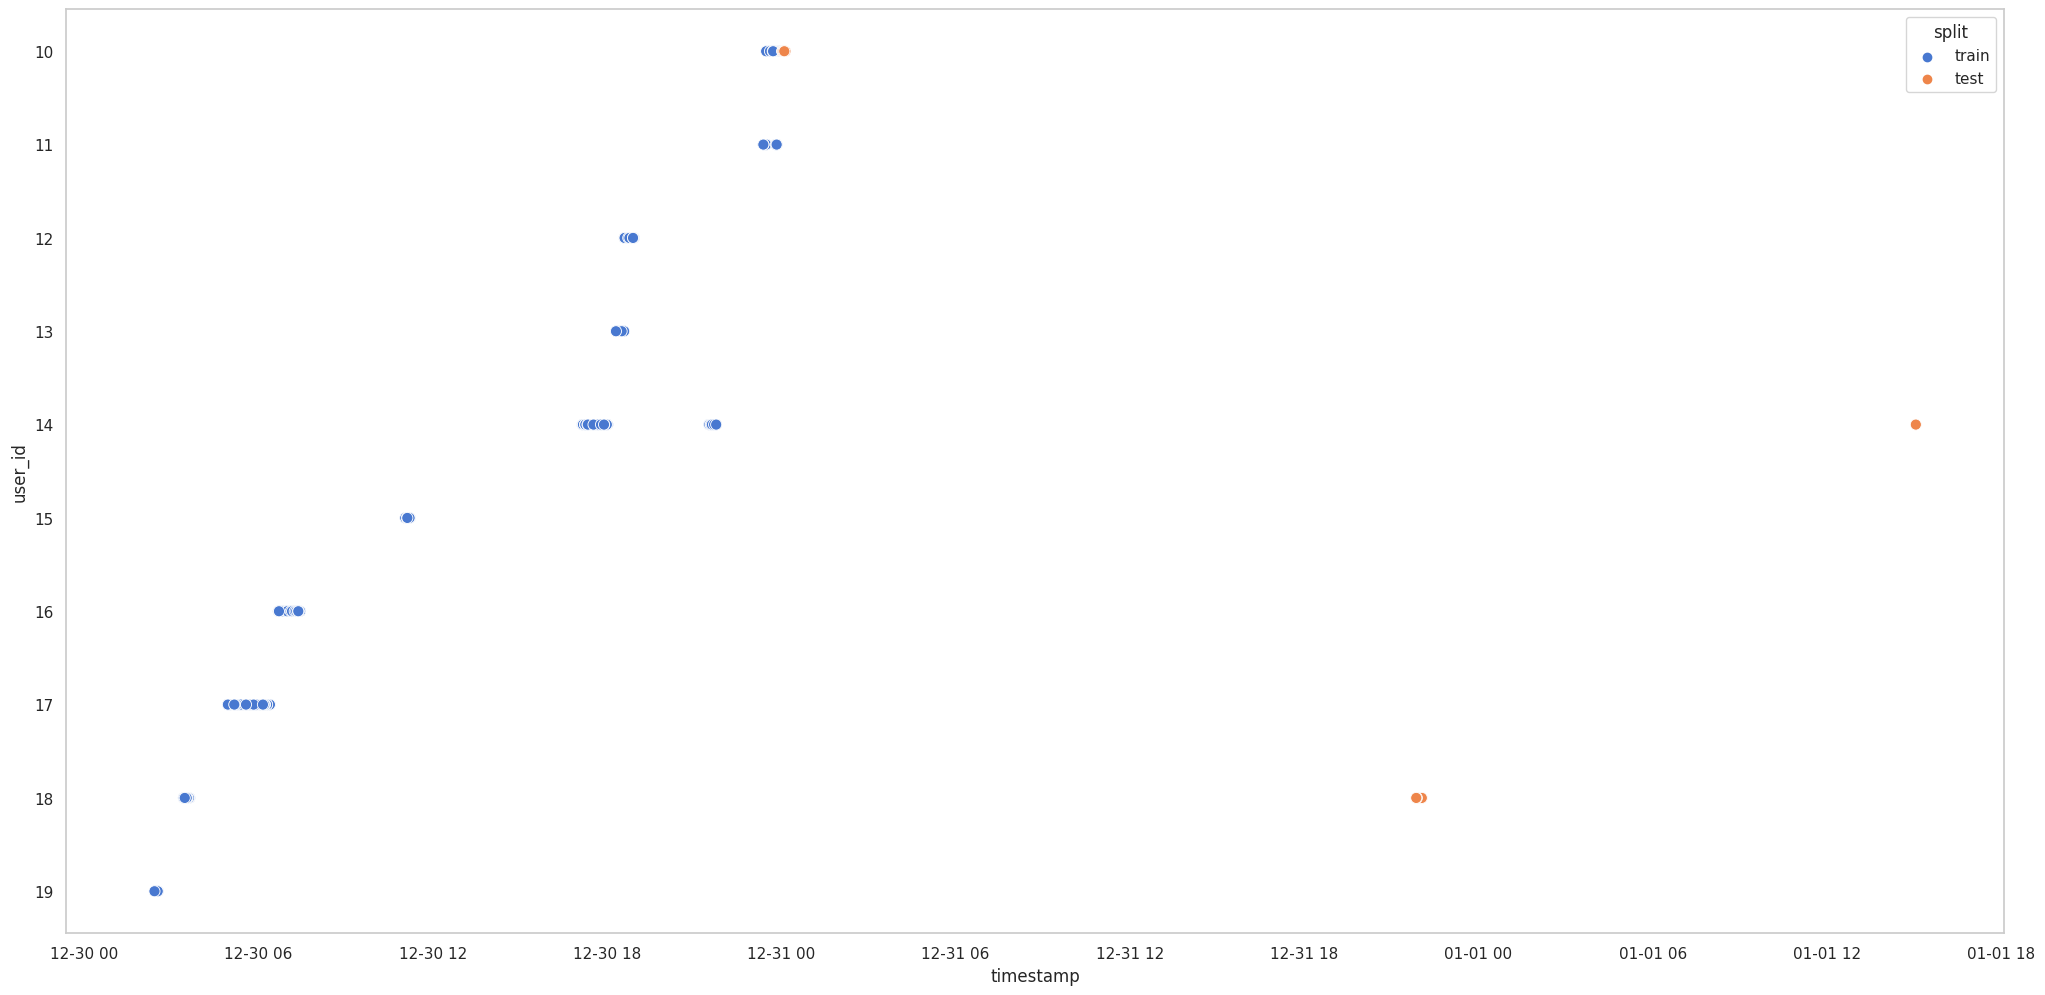

In [94]:
show_train_test(train, test)

In [95]:
get_df_info(train)

Total rows 1024, unique users: 10, unique items: 673


In [96]:
get_df_info(test)

Total rows 24, unique users: 3, unique items: 24


### Learn more about the parameters `drop_cold_users`, `drop_cold_items`, `drop_zero_rel_in_test`

#### All parameters is false

In [97]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()`

In [98]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 300065, unique users: 2283, unique items: 3572


#### `drop_cold_users` is True 

In [99]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=True,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_users=True`. Compared to the disabled flag, the number of users has decreased.

In [100]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 111169, unique users: 1113, unique items: 3459


#### `drop_cold_items` is True 

In [101]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=True,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_items=True`. Compared to the disabled flag, the number of items has decreased.

In [102]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 299894, unique users: 2283, unique items: 3499


## class RandomSplitter()

Assign records into train and test at random.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [103]:
from replay.splitters import RandomSplitter

random_splitter = RandomSplitter(
    test_size=0.4,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [104]:
train, test = random_splitter.split(log_limit_20)

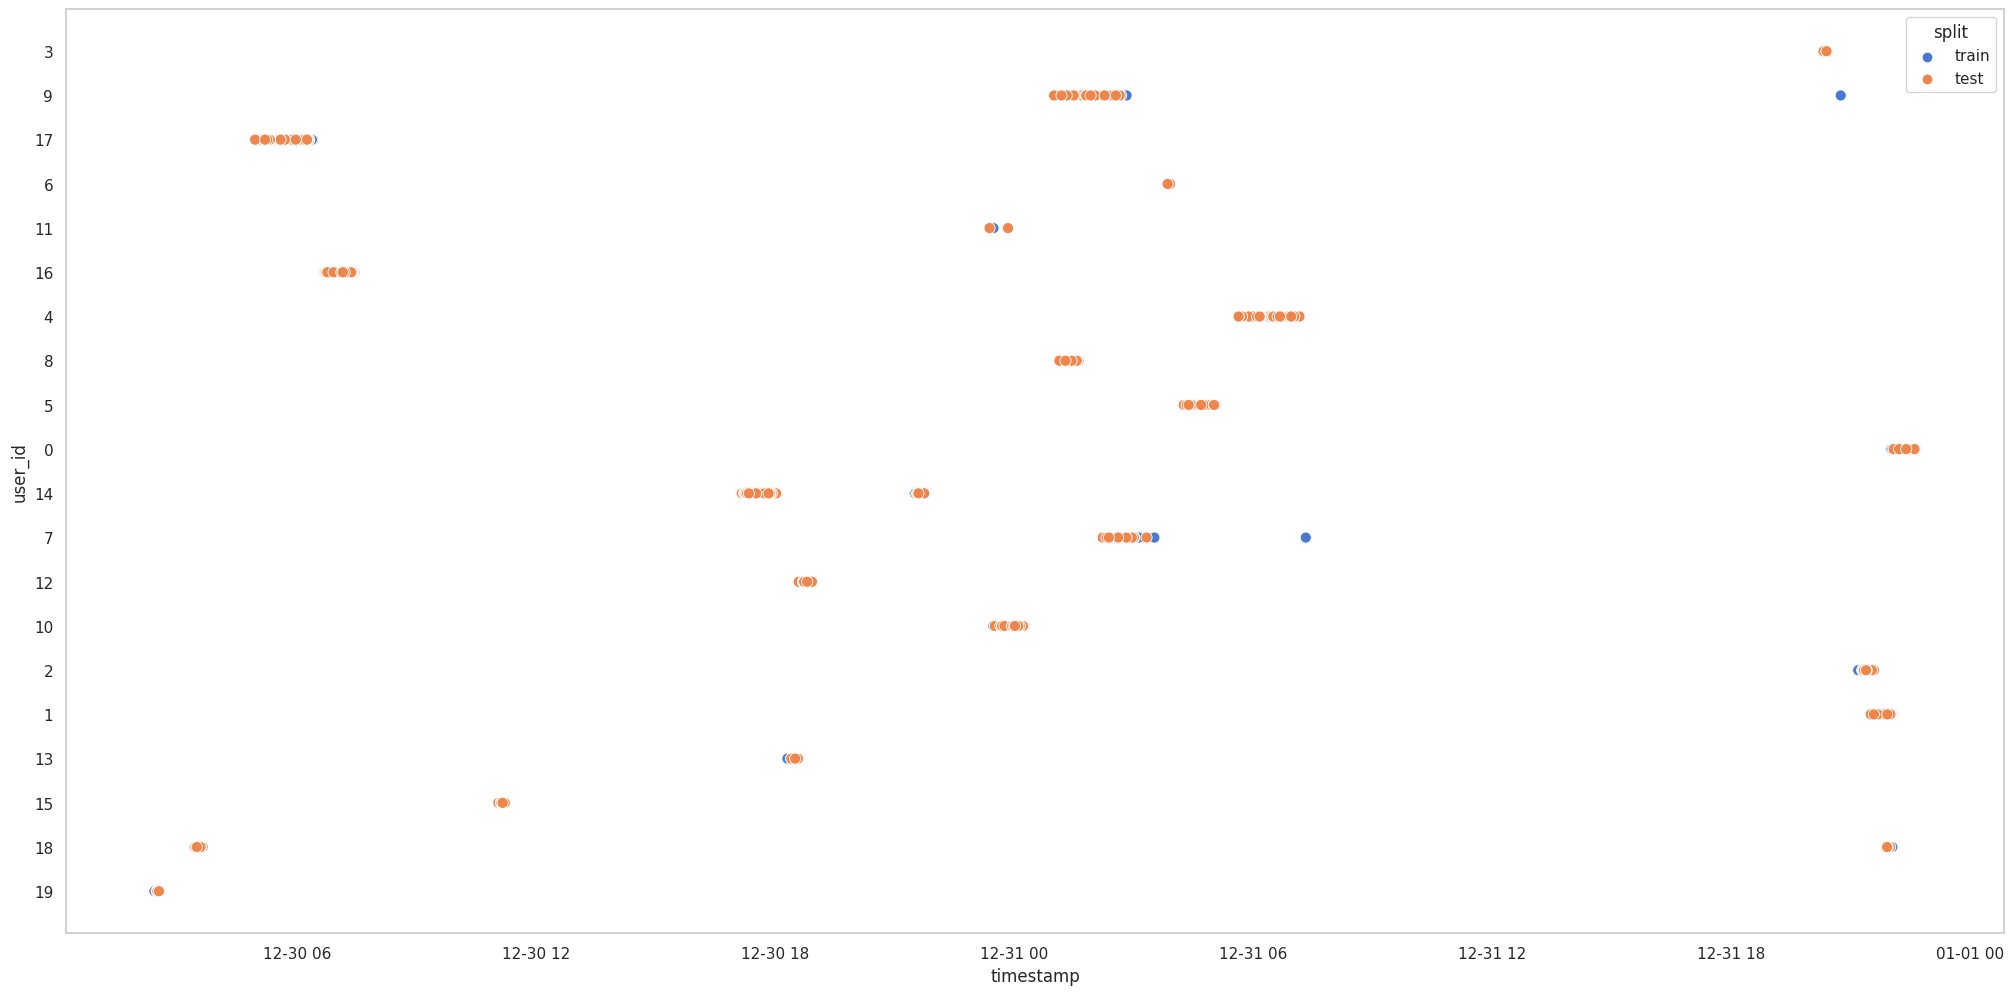

In [105]:
show_train_test(train, test)

In [106]:
get_df_info(train)

Total rows 1295, unique users: 20, unique items: 762


In [107]:
get_df_info(test)

Total rows 495, unique users: 20, unique items: 292


## class NewUsersSplitter()

Only new users will be assigned to test set.
Splits log by timestamp so that test has `test_size` fraction of most recent users.

#### Parameters other than general

* `test_size` float 

In [108]:
from replay.splitters import NewUsersSplitter

new_user_splitter = NewUsersSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [109]:
train, test = new_user_splitter.split(log_limit_20)

/tmp/ipykernel_997225/2154144320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plt["split"] = 'train'


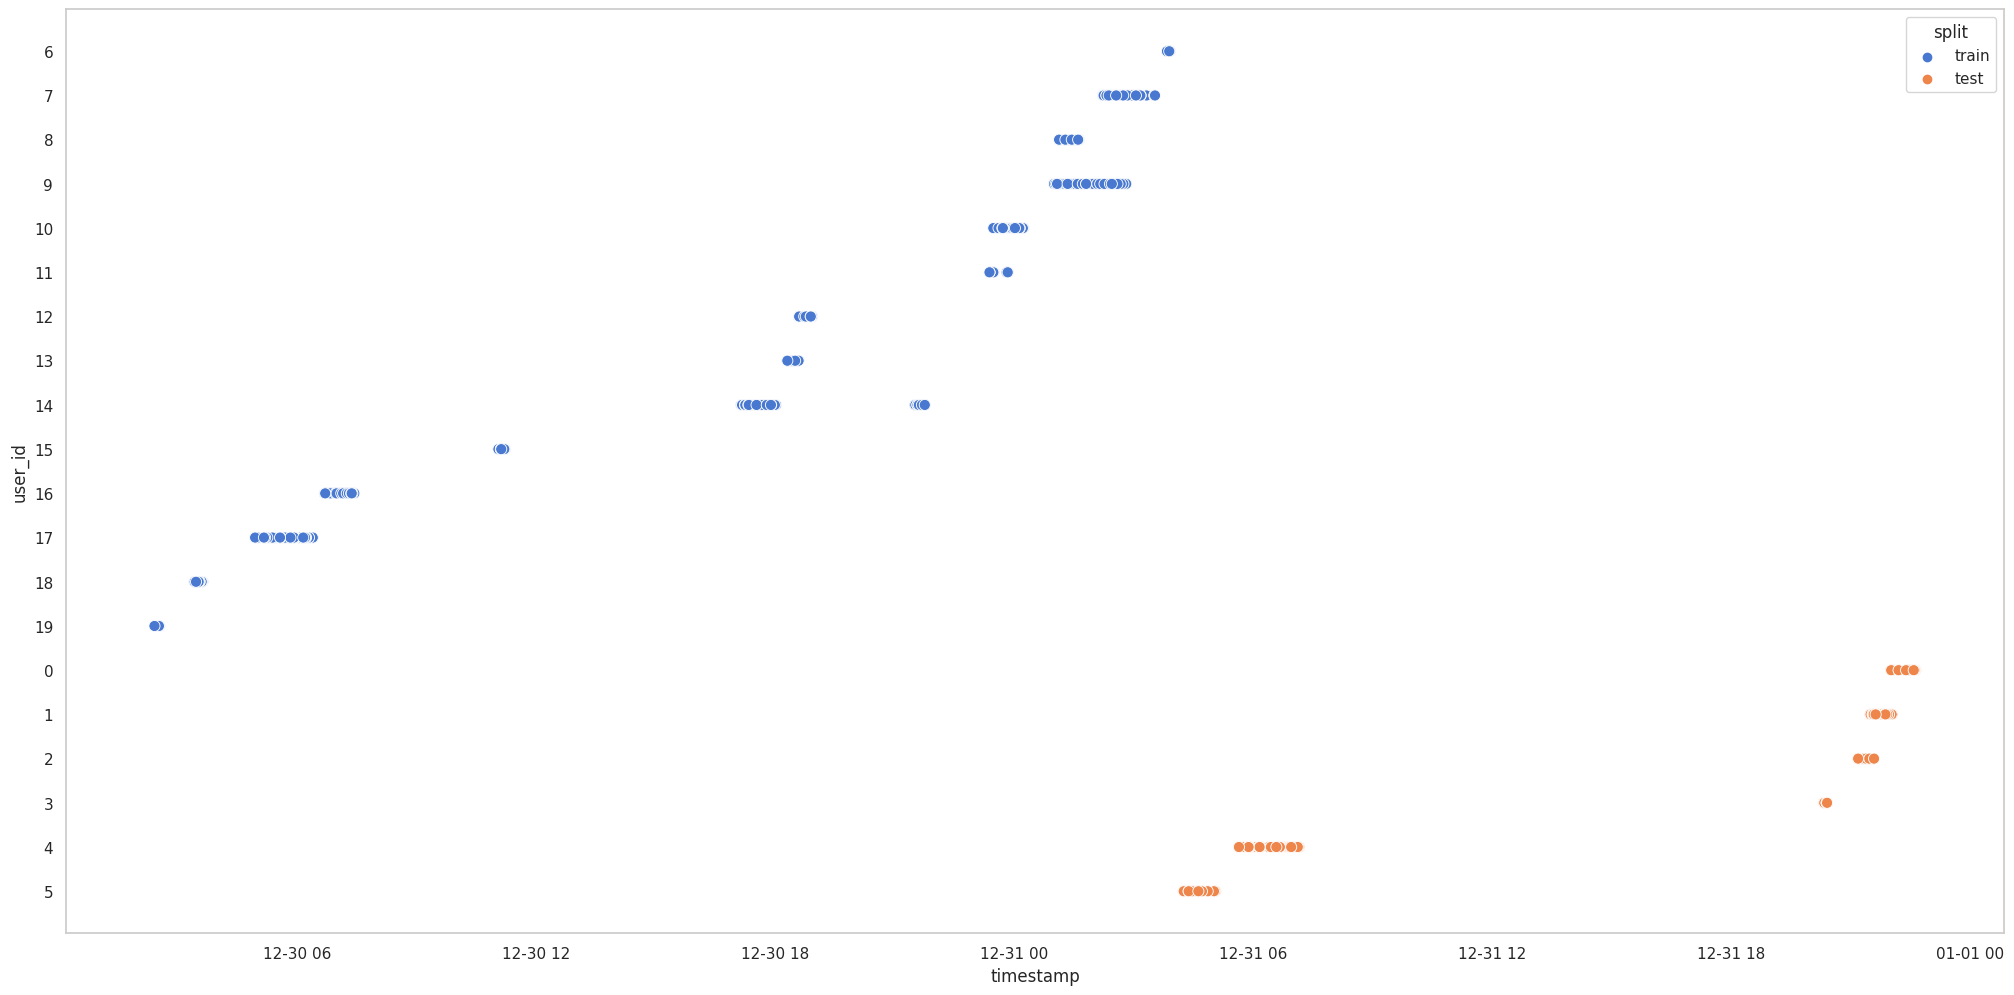

In [110]:
show_train_test(train, test)

In [111]:
get_df_info(train)

Total rows 1616, unique users: 14, unique items: 905


In [112]:
get_df_info(test)

Total rows 510, unique users: 6, unique items: 423


## class ColdUserRandomSplitter()

Test set consists of all actions of randomly chosen users.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [113]:
from replay.splitters import ColdUserRandomSplitter

cold_user_random_splitter = ColdUserRandomSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [114]:
train, test = cold_user_random_splitter.split(log_limit_20)

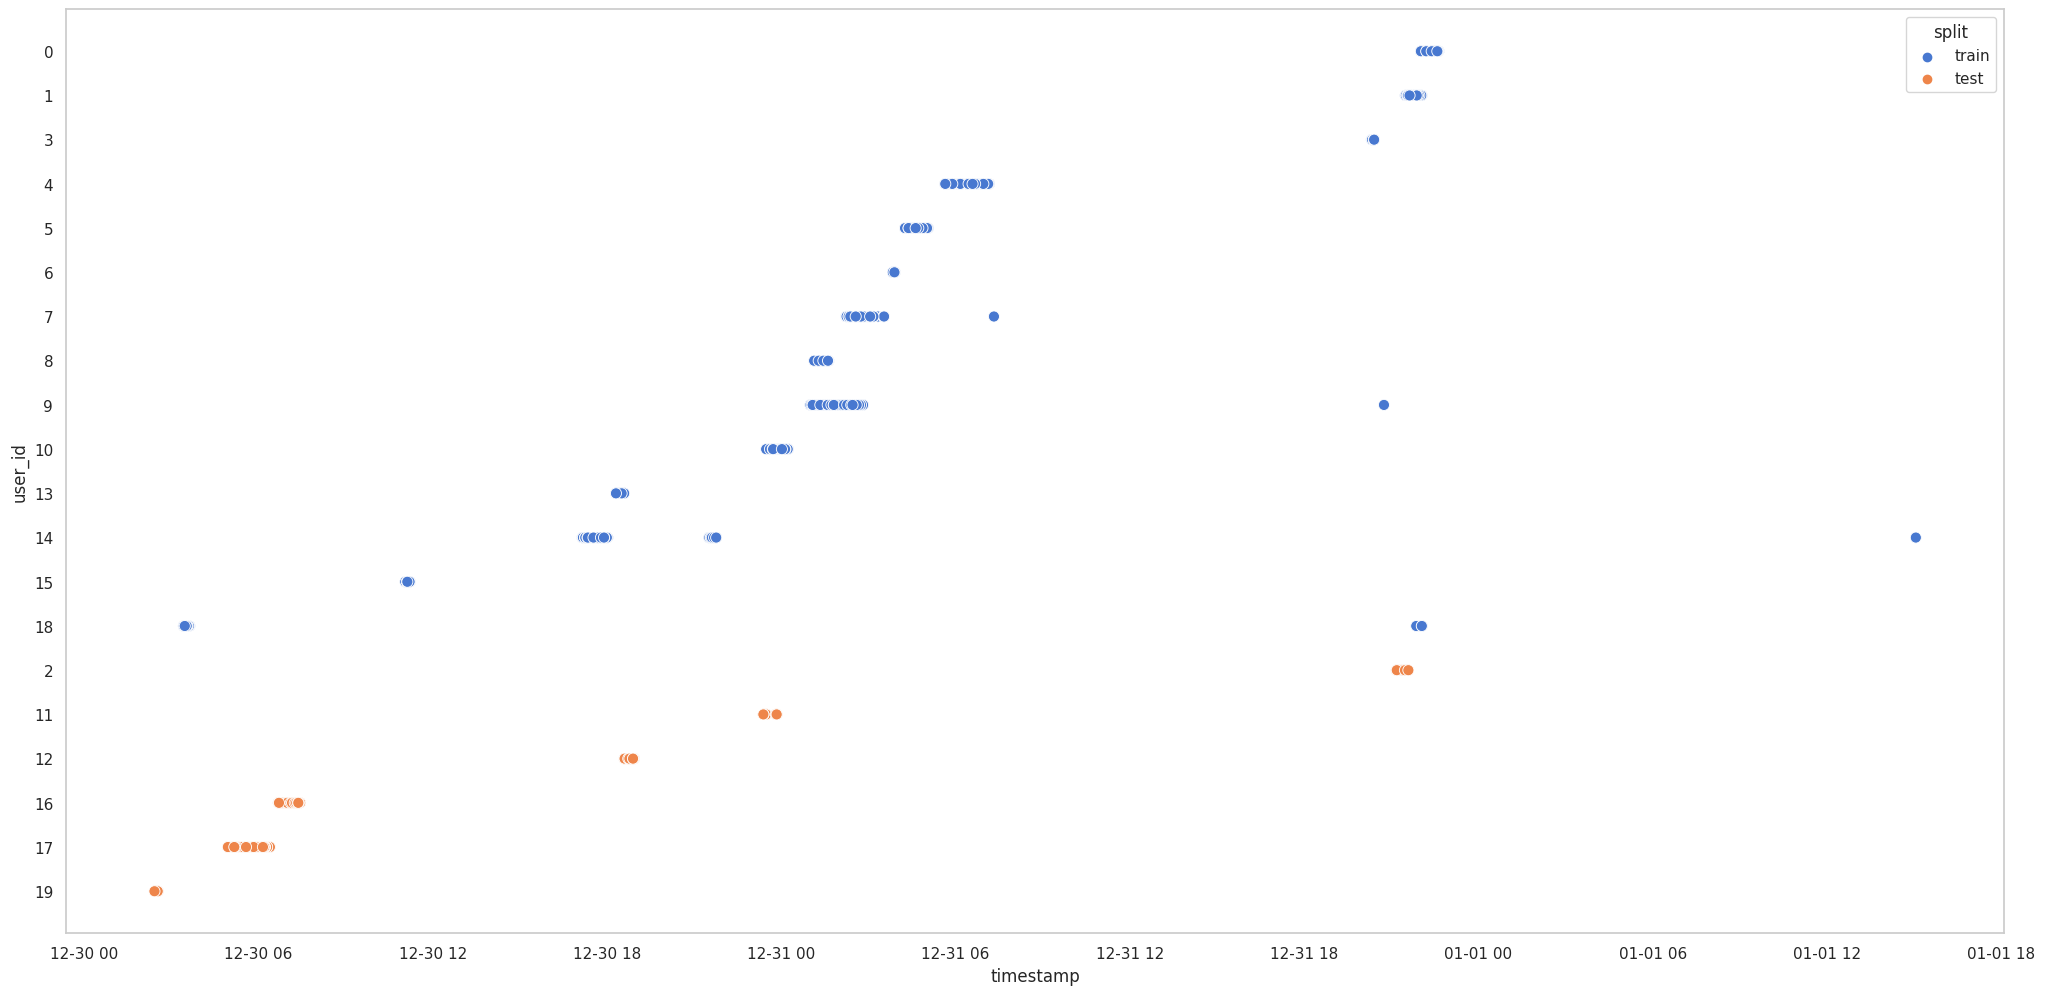

In [115]:
show_train_test(train, test)

In [116]:
get_df_info(train)

Total rows 1447, unique users: 14, unique items: 838


In [117]:
get_df_info(test)

Total rows 711, unique users: 6, unique items: 532


## class TwoStageSplitter()

Split data by two columns.

#### Parameters other than general

* `item_test_size` Number of items to be added to the test for each user

* `user_test_size` Number of users to be added to the test

* `seed` random seed

In this example 10 users are randomly selected, 50 products are included in the test for each user. `shuffle` parameter is False. Separation in each selected user occurs on a timeline

In [118]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=False,
    query_column="user_id",
    first_divide_column="user_id",
)

In [119]:
train, test = user_splitter.split(log_limit_20)

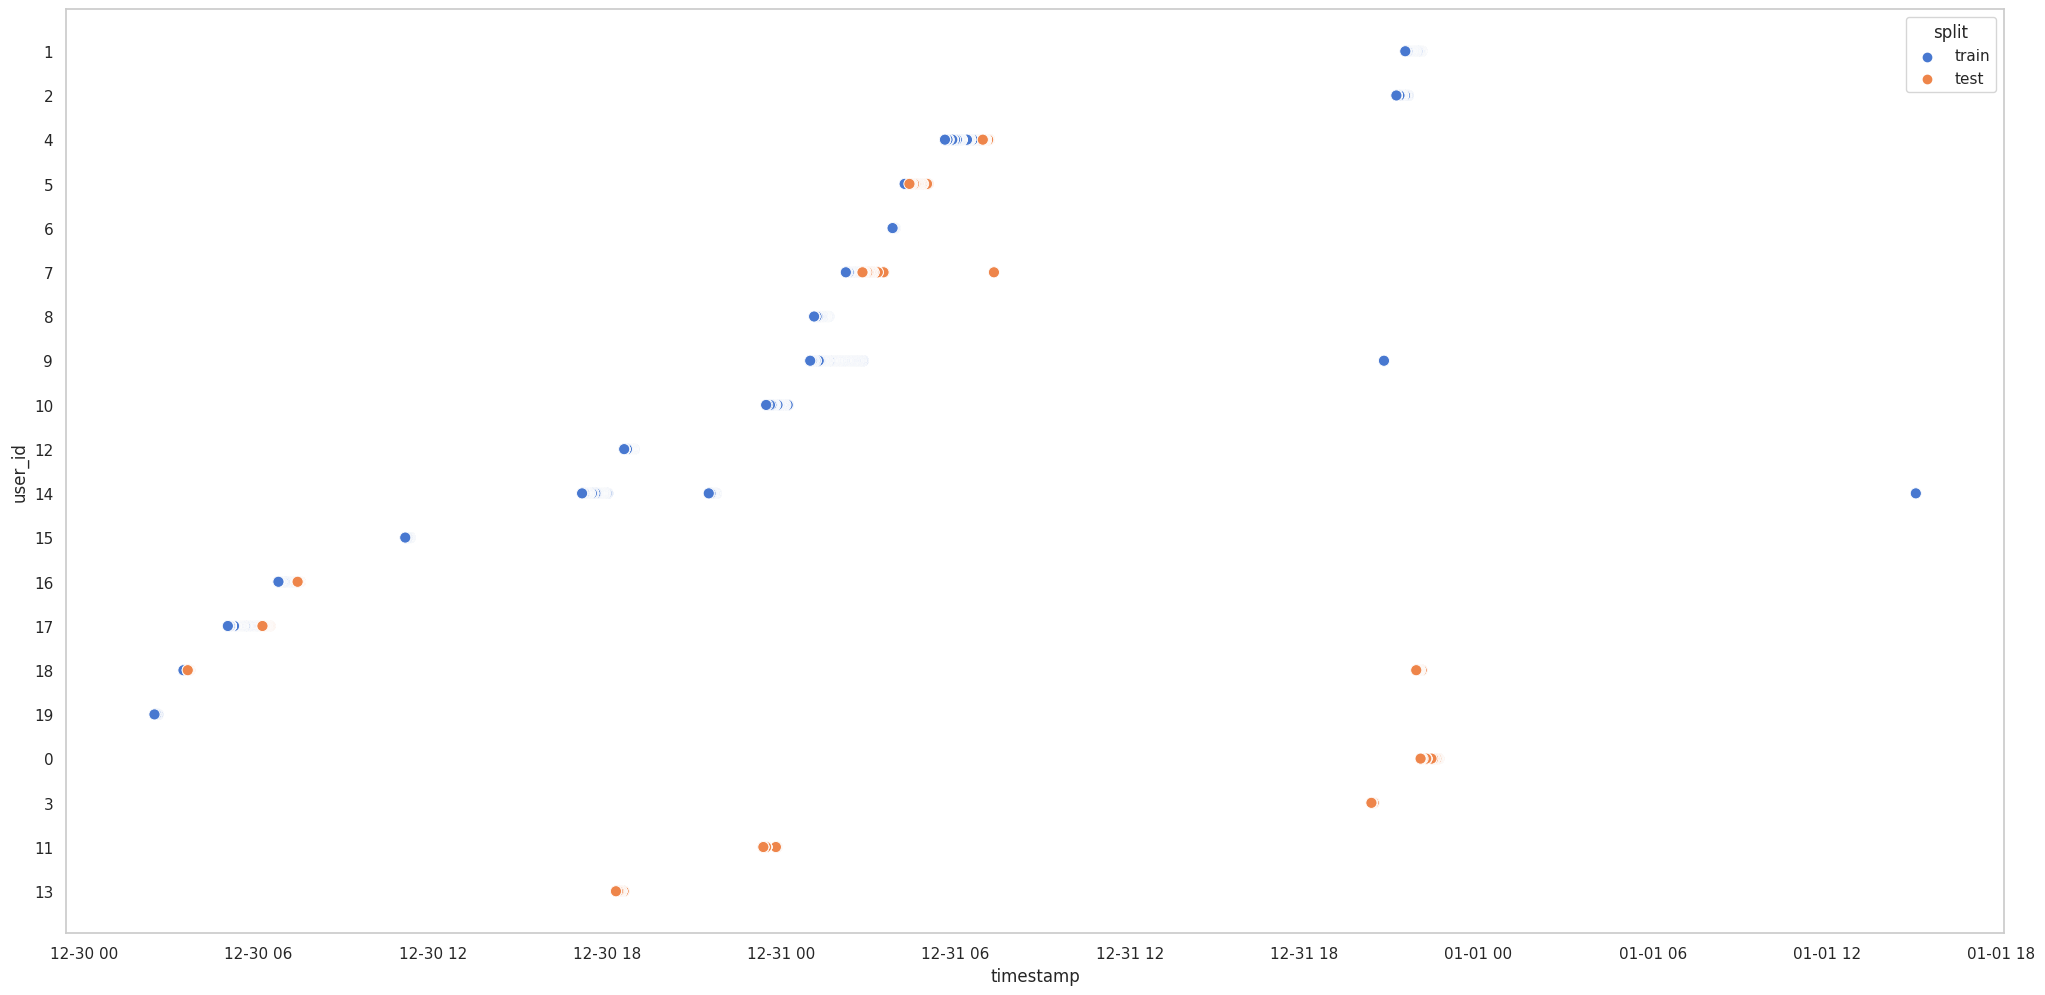

In [120]:
show_train_test(train, test)

In [121]:
get_df_info(train)

Total rows 1749, unique users: 16, unique items: 922


In [122]:
get_df_info(test)

Total rows 409, unique users: 10, unique items: 352


In this example 10 users are randomly selected, 50 products are included in the test for each user. In this example `shuffle` parameter is True. Split in each selected user occurs random

In [123]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [124]:
train, test = user_splitter.split(log_limit_20)

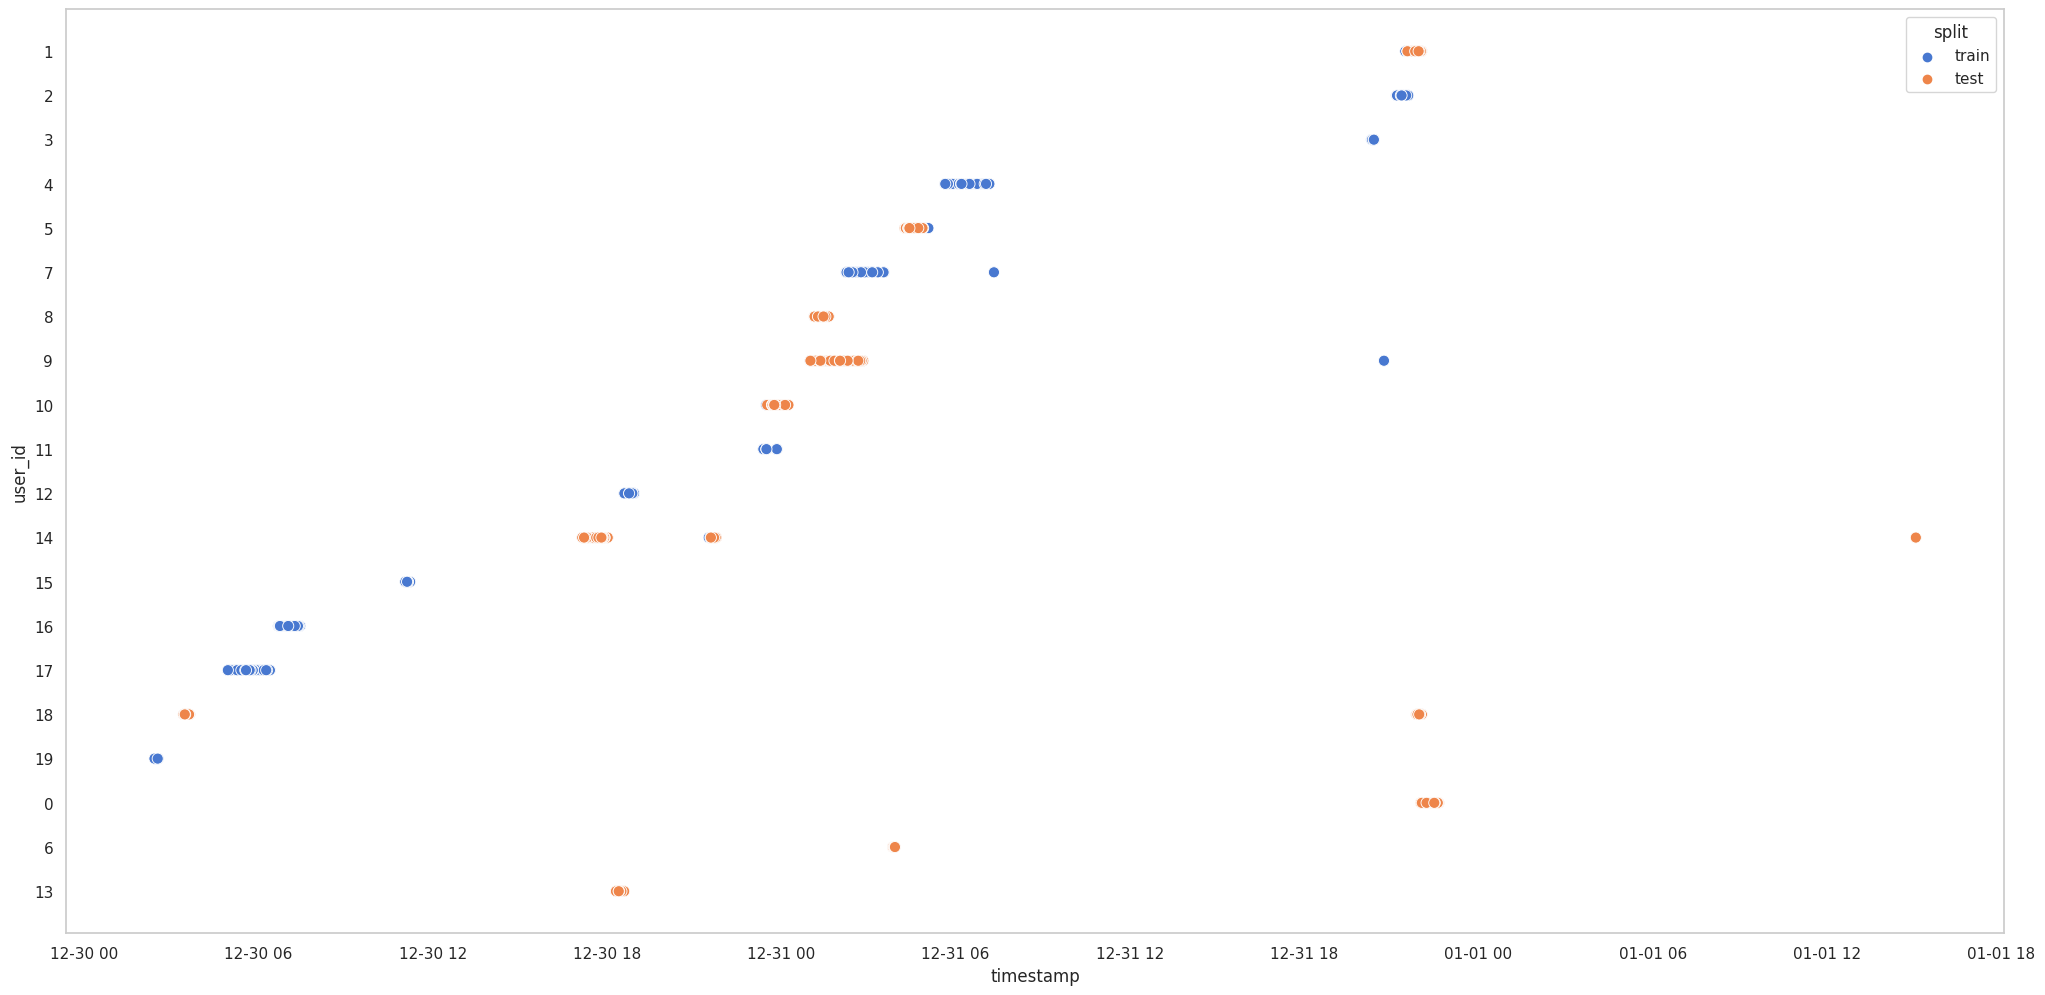

In [125]:
show_train_test(train, test)

In [126]:
get_df_info(train)

Total rows 1712, unique users: 17, unique items: 966


In [127]:
get_df_info(test)

Total rows 446, unique users: 10, unique items: 346


You can use **float** as input for `item_test_size` or `user_test_size` parameters

In [128]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=0.5,
    second_divide_size=0.015,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [129]:
train, test = user_splitter.split(log_limit_20)

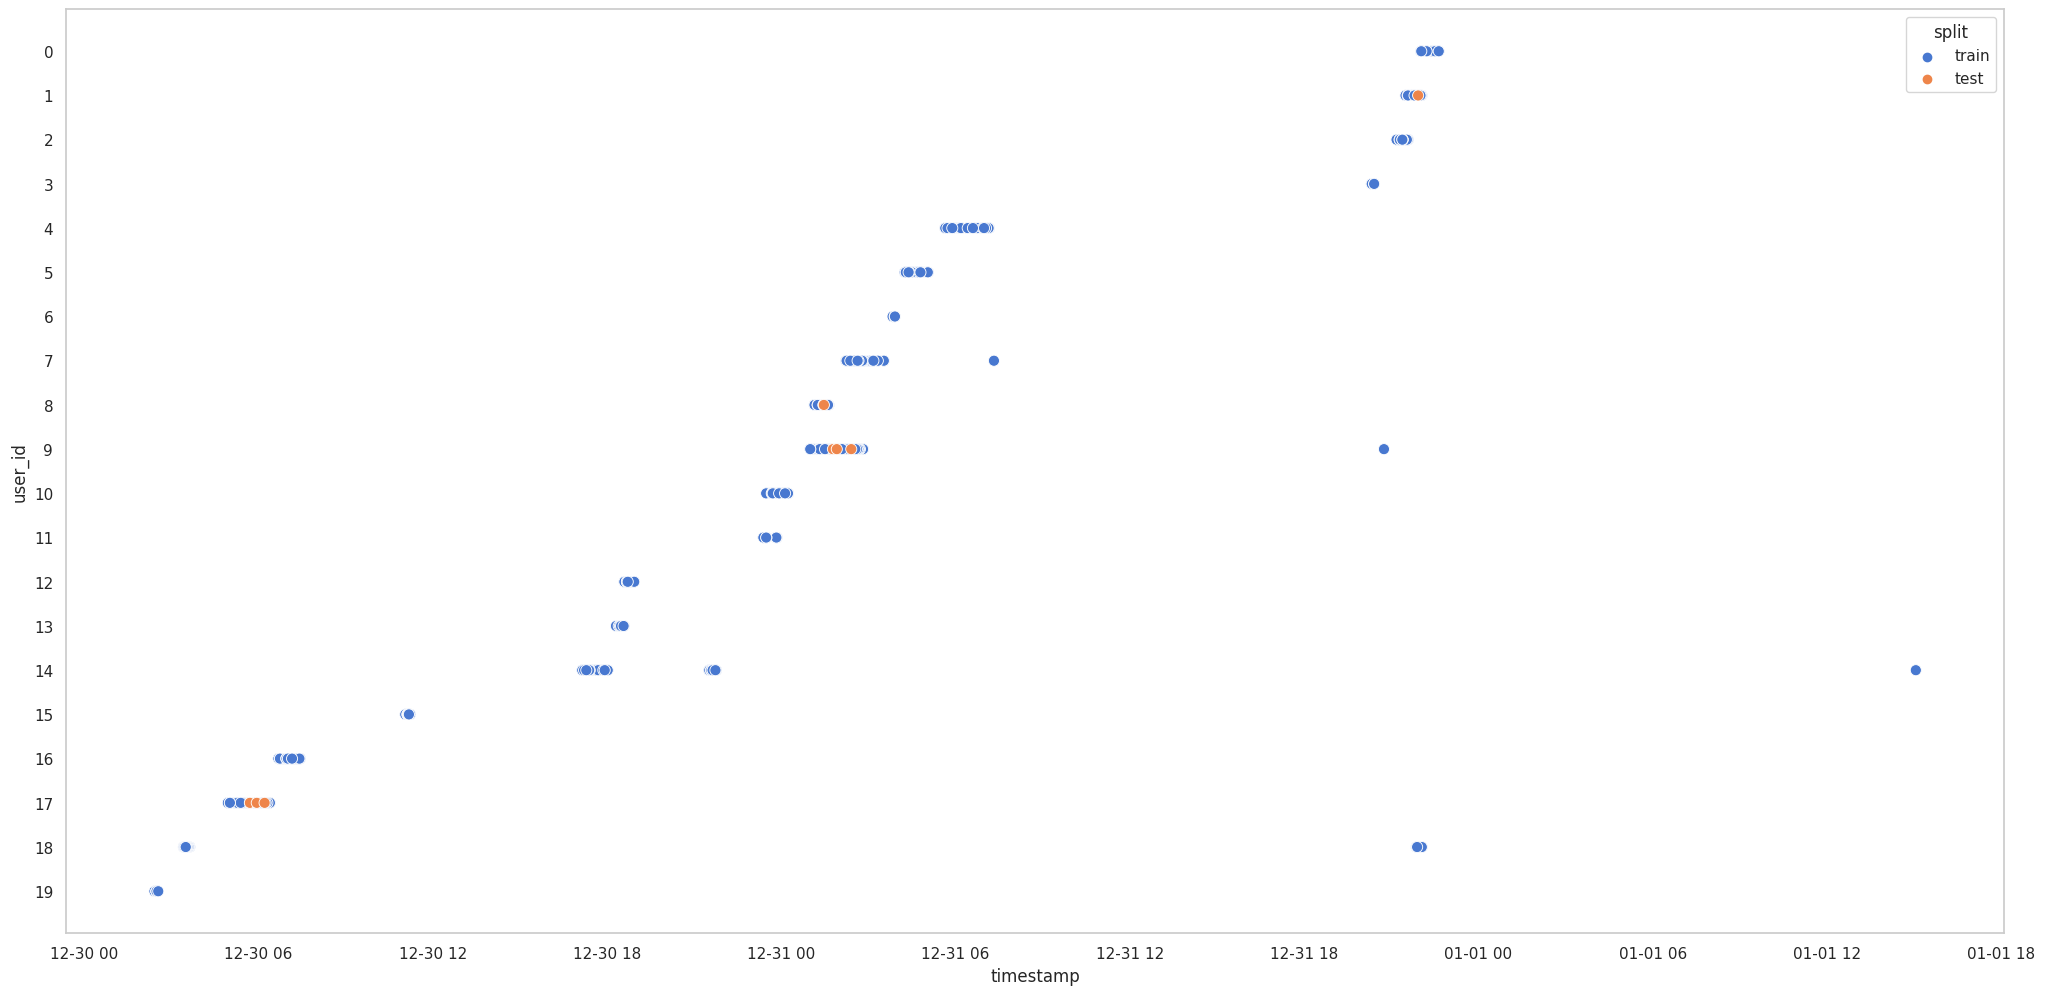

In [130]:
show_train_test(train, test)

In [131]:
get_df_info(train)

Total rows 2148, unique users: 20, unique items: 1064


In [132]:
get_df_info(test)

Total rows 10, unique users: 4, unique items: 10
